In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from scipy.stats import t
# import colorcet as cc

import pymc as pm
import arviz as az

import sys
import os
# os.chdir('/home/nlinden_local/Dropbox/lab-comp-research/proj_4_multiModelModeling/multiModelModeling/src/test_enzyme_kinetics')
sys.path.insert(0, '../')
from winkler_1981 import *

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')
mpl.rcParams['figure.autolayout'] = False
cb = sns.color_palette(palette='colorblind', n_colors=4)
# cb = sns.color_palette(palette='crest', n_colors=4)

# Toy model to better understand the model comparison methods

We will use the "enzyme kinetics" model show in the appendix of Transtrum and Qiu. PRL. 2014. 
The model is
$$
 y(u, \boldsymbol{\theta}) = \frac{\theta_1(u^2 + \theta_2 u)}{u^2 + \theta_3 u + \theta_4}
$$
where $u$ is a substrate concentration of the reaction and $\boldsymbol{\theta}$ are the model parameters.

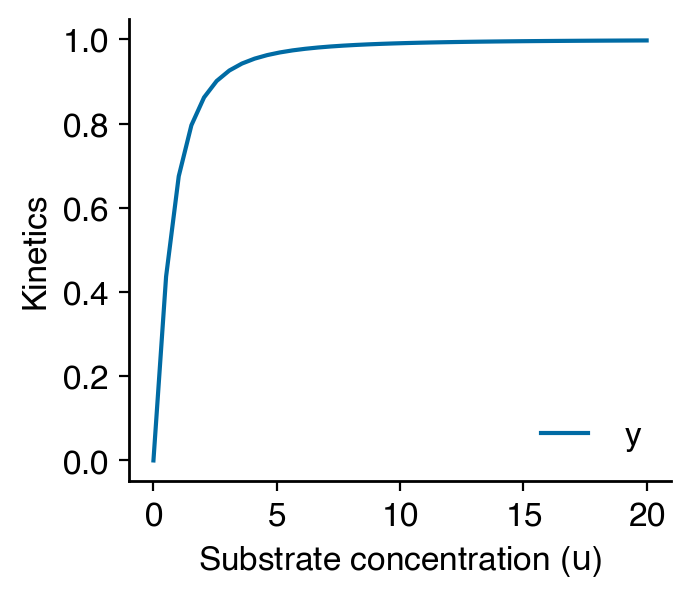

In [2]:
# function for the model
def sub_enz(u, theta): # full order model
    return (theta[0]*(u**2 + theta[1]*u))/(u**2 + theta[2]*u + theta[3])

# test the model
theta = np.array([1.0, 1.0, 1.0, 1.0])
u = np.linspace(0, 20, 40)
vals = sub_enz(u, theta)
data = {'u':u, 'y':vals}

#plot
fig, ax = plt.subplots(figsize=(3.5,3))
sns.set_palette(cb)
sns.lineplot(data=data, x='u', y='y', ax=ax)
ax.legend('y')
ax.set_xlabel('Substrate concentration ($u$)')
ax.set_ylabel('Kinetics')
plt.show()

### Developing a several alternative models
1. **Reduced model from Transtrum and Qui.** This model was found by using the MBAM method to reduce the original model. The model is
$$
    y(u, \boldsymbol{\phi}) = \frac{\phi_1 u}{u^2 + \phi_2 u + \phi_3},
$$
where $\phi_1 = \theta_1 \theta_2$, $\phi_2 = \theta_3$ and $\phi_3 = \theta_4$, where $\theta_i$ are the parameters of the full order model.

2. **Scalar minus a decaying exponential** 
$$
y(u, \boldsymbol{\lambda}) = \lambda_1 - \lambda_2 \exp(-\lambda_3 u)
$$

3. **Sigmoid**
$$
y(u, \boldsymbol{\beta}) = \beta_1 + \frac{\beta_2}{\beta_3 + \beta_4 \exp(-\beta_5 u)}
$$


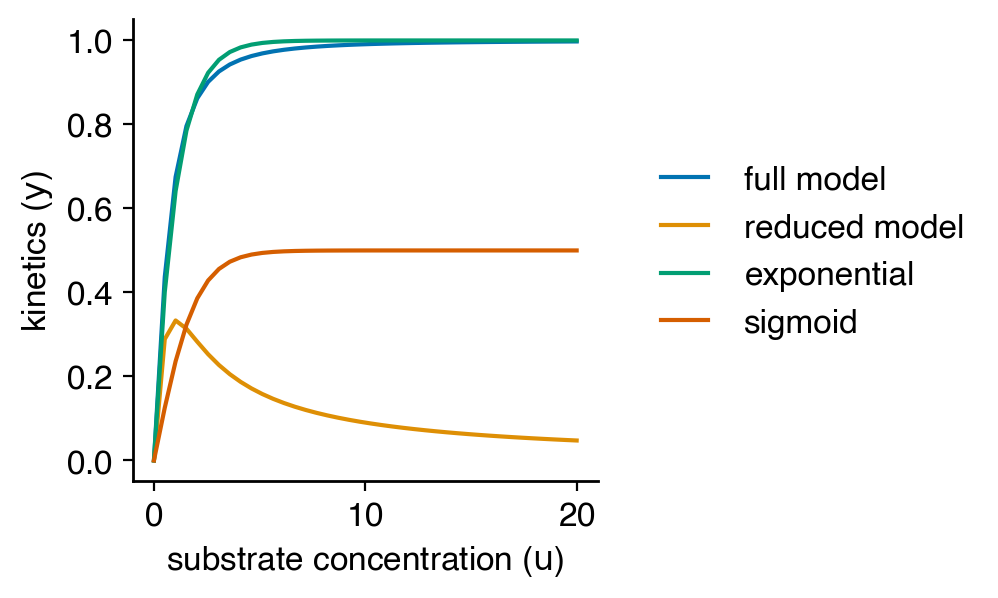

In [3]:
def sub_enz_red(u, phi): # reduced order model
    return (phi[0]*u)/(u**2 + phi[1]*u + phi[2])

def scal_exp(u, theta):
    return theta[0] - theta[1]*np.exp(-theta[2]*u)

def sigmoid(x, theta):
  return theta[0] + (theta[1] / (theta[2] + theta[3]*np.exp(-theta[4]*x)))

# test the model
phi = np.array([1.0, 1.0, 1.0]) # params for red model
theta_exp = np.array([1.0, 1.0, 1.0]) # params for exponential model
theta_sig = np.array([-0.5, 1.0, 1.0, 1.0, 1.0]) # params for sigmoid model
u = np.linspace(0, 20, 40)
vals_red = sub_enz_red(u, phi)
vals_exp = scal_exp(u, theta_exp)
vals_sig = sigmoid(u, theta_sig)

# create dict for seaborn
data_red = {'u':u, 'y':vals_red}
data_exp = {'u':u, 'y':vals_exp}
data_sig = {'u':u, 'y':vals_sig}

fig, ax = plt.subplots(figsize=(3,3))
sns.set_palette(cb)
sns.lineplot(data=data, x='u', y='y', ax=ax, label='full model')
sns.lineplot(data=data_red, x='u', y='y', ax=ax, label='reduced model')
sns.lineplot(data=data_exp, x='u', y='y', ax=ax, label='exponential')
sns.lineplot(data=data_sig, x='u', y='y', ax=ax, label='sigmoid')
ax.legend(bbox_to_anchor=(1.05, 0.75))
ax.set_xlabel(r'substrate concentration ($u$)')
ax.set_ylabel('kinetics ($y$)')
plt.show()
fig.savefig('../../figures/enzyme_kinetics/kinetics_models.pdf', bbox_inches='tight')

We now want to generate some data from the full model to use to for parameter estimation of all models. To do so, we will subsample (in time) the simulation and Gaussian noise to the measurements.

[ 0.          4.1025641   8.20512821 12.30769231 16.41025641]


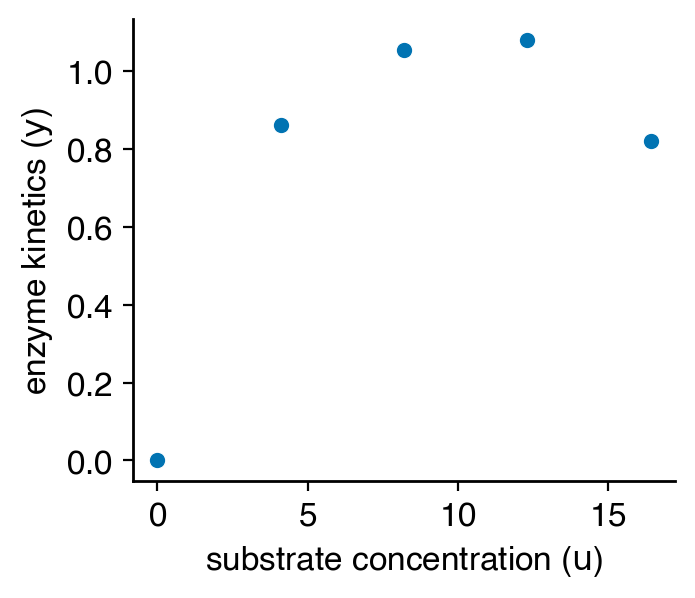

In [4]:
rng = np.random.default_rng(seed=42)

noisy_data = vals[0:40:8]
noisy_data = noisy_data + 0.09*rng.standard_normal(noisy_data.shape[0])
noisy_data[0] = 0 # set first point to 0
u_samp = u[0:40:8]
print(u_samp)

# create dict for seaborn
dat = {'u':u_samp, 'y':noisy_data}

#plot
fig, ax = plt.subplots(figsize=(3.5,3))
sns.set_palette(cb)
# sns.lineplot(data=data, x='u', y='y', ax=ax, label='full model')
sns.scatterplot(data=dat, x='u', y='y', ax=ax)
# ax.legend()
ax.set_xlabel('substrate concentration ($u$)')
ax.set_ylabel('enzyme kinetics ($y$)')
plt.show()
fig.savefig('../../figures/enzyme_kinetics/kinetics_data.pdf', bbox_inches='tight')

Now create pymc models for each model and estimate the model parameters. All priors will be Lognormal with $\mu = 0$ and $\sigma = 0.5$

Start with the full model.

In [5]:
u_samp_sqr = u_samp**2

[ 0.          4.1025641   8.20512821 12.30769231 16.41025641]


Sampling: [Y_obs, sigma, theta_1, theta_2, theta_3, theta_4]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2, theta_3, theta_4, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


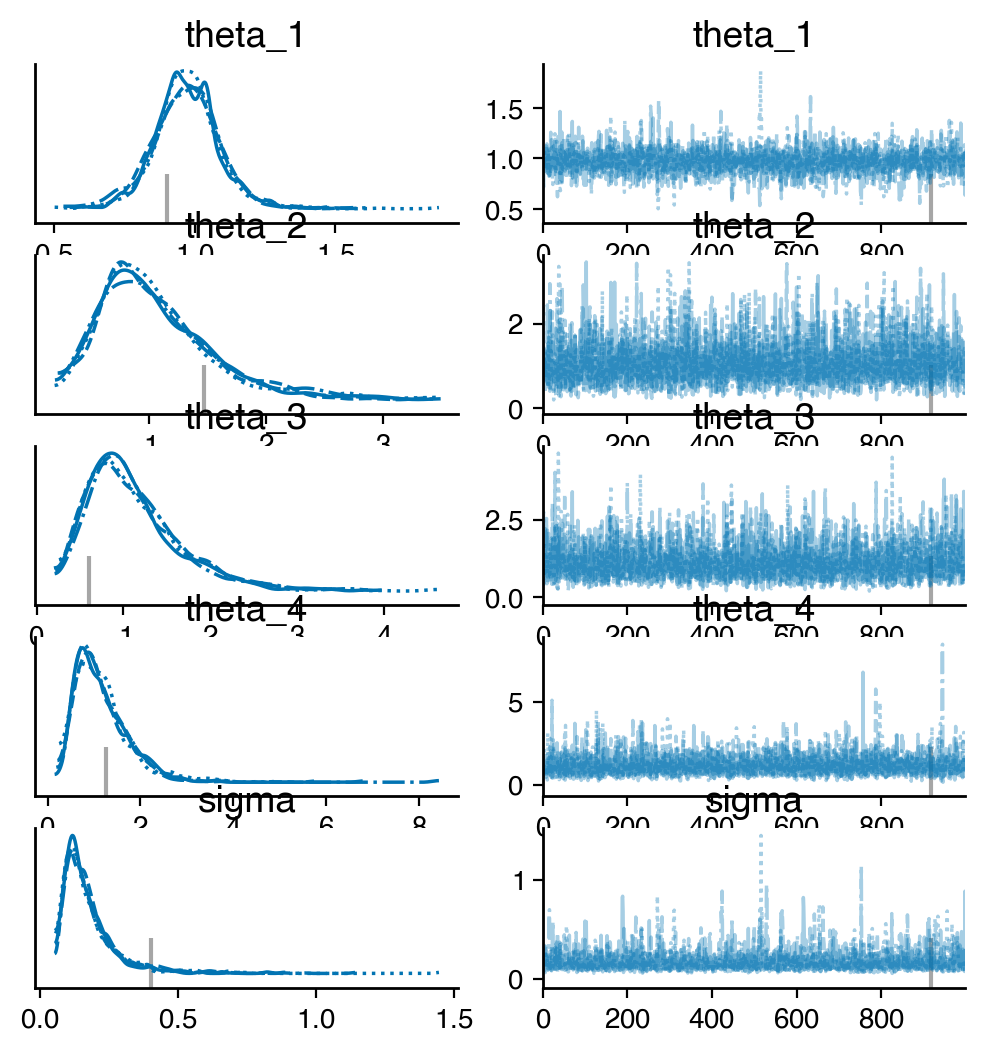

In [6]:
# full model
full_enz_kin = pm.Model()
with full_enz_kin:
    # priors
    theta_1 = pm.LogNormal("theta_1", mu=0.0, sigma=0.5)
    theta_2 = pm.LogNormal("theta_2", mu=0.0, sigma=0.5)
    theta_3 = pm.LogNormal("theta_3", mu=0.0, sigma=0.5)
    theta_4 = pm.LogNormal("theta_4", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # compute model
    print(u_samp)
    y = (theta_1*(u_samp_sqr + theta_2*u_samp))/(u_samp_sqr + theta_3*u_samp + theta_4)

    # Likelihood of obs
    y_obs = pm.Normal("Y_obs", mu=y, sigma=sigma, observed=noisy_data)

# MCMC sample
with full_enz_kin: # sampling
    idata_full_enz_kin_prior = pm.sample_prior_predictive(samples=50, random_seed=rng)
    idata_full_enz_kin = pm.sample(random_seed=rng, idata_kwargs={'log_likelihood':True})

# plot traces and marginal densities
fig, ax = plt.subplots(5,2, figsize=(6,6))
az.plot_trace(idata_full_enz_kin, axes=ax)
plt.show()

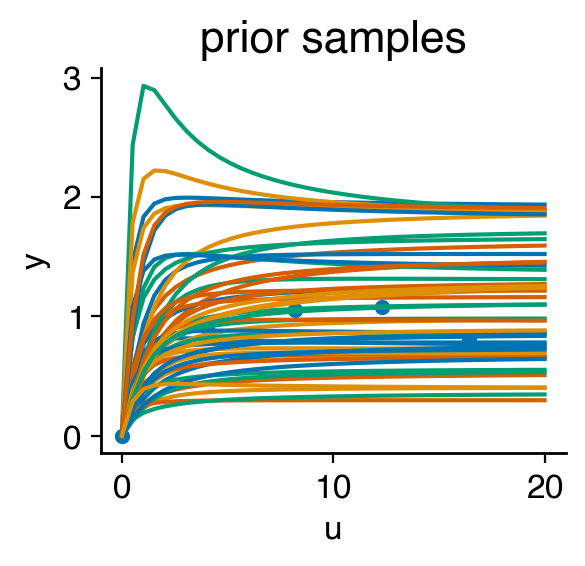

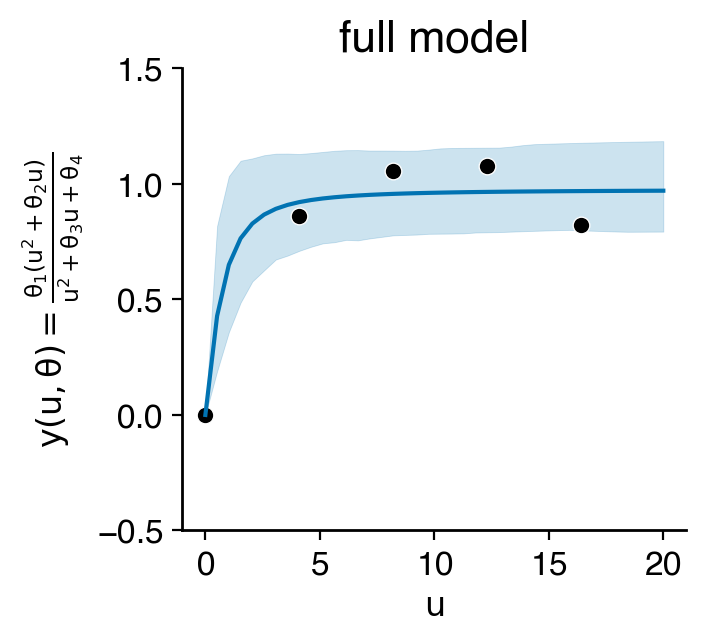

In [7]:
prior_samples = idata_full_enz_kin_prior.to_dict()['prior']
fig, ax = plt.subplots(figsize=(3,2.5))
# prior
for i in range(50):
    theta = np.array([prior_samples['theta_1'][0][i],
                      prior_samples['theta_2'][0][i],
                      prior_samples['theta_3'][0][i],
                      prior_samples['theta_4'][0][i]])
    vals = sub_enz(u, theta)
    data = {'u':u, 'y':vals}
    sns.lineplot(data, x='u', y='y', ax=ax)
sns.scatterplot(data=dat, x='u', y='y', ax=ax)
ax.set_title('prior samples')

# posterior
fig1, ax1 = plt.subplots(figsize=(3.25,3))
posterior_samples = idata_full_enz_kin.to_dict()['posterior']
full = {'run':{}, 'u':{}, 'y':{}}
full_ss = np.zeros((400,))
names = ['run'+str(i) for i in range(400)]
idxs = np.linspace(0, (400*u.shape[0]-1), 400*u.shape[0])
cnt = 0
for i in range(400):
    theta = np.array([posterior_samples['theta_1'].flatten()[i],
                        posterior_samples['theta_2'].flatten()[i],
                        posterior_samples['theta_3'].flatten()[i],
                        posterior_samples['theta_4'].flatten()[i]])
    vals = sub_enz(u, theta)
    full_ss[i] = vals[-1]
    for j in range(u.shape[0]):
        full['run'][int(idxs[cnt])] = names[i]
        full['u'][int(idxs[cnt])] = u[j]
        full['y'][int(idxs[cnt])] = vals[j]
        cnt += 1
full_df=pd.DataFrame.from_dict(full,)
sns.lineplot(data=full_df,
            x='u',
            y='y',
            # style='patient',
            # hue='patient',
            color=cb[0],
            legend=False,
            errorbar=('pi', 95), # percentile interval form 2.5th to 97.5th
            ax=ax1)
sns.scatterplot(data=dat, x='u', y='y', ax=ax1, color='k')
ax1.set_title('full model')
ax1.set_ylabel(r'$y(u, \theta) = \frac{\theta_1(u^2 + \theta_2 u)}{u^2 + \theta_3 u + \theta_4}$')
ax1.set_xlabel(r'$u$')
ax1.set_ylim([-0.5, 1.5])
# ax1.set_aspect()
fig1.savefig('../../figures/enzyme_kinetics/full_post_traj.pdf', bbox_inches='tight')
plt.show()

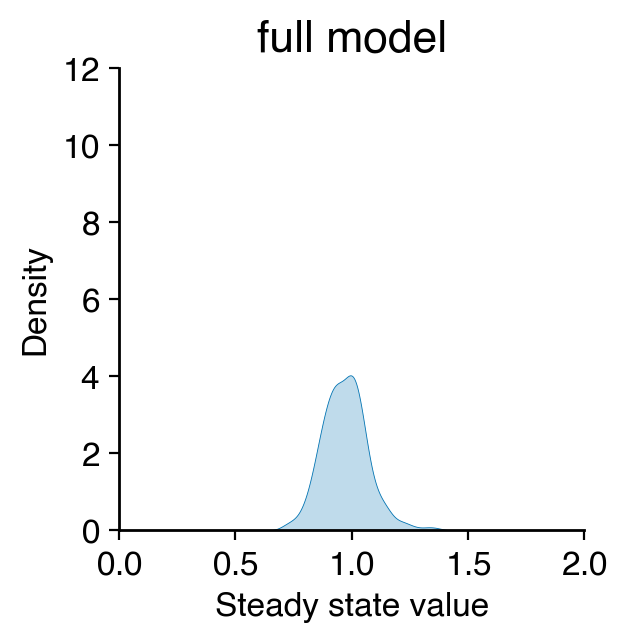

In [8]:
fig2, ax2 = plt.subplots(figsize=(3,3))
dns = sns.kdeplot(full_ss,
            fill=True,
            ax=ax2, 
            color=cb[0], 
            label='full model')
dns.set_xlabel('Steady state value')
dns.set_title('full model')
dns.set_xlim([0, 2.0])
dns.set_ylim([0, 12.0])
fig2.savefig('../../figures/enzyme_kinetics/full_post_dist.pdf', bbox_inches='tight')

Now for the reduced model...

Sampling: [Y_obs, phi_1, phi_2, phi__3, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi_1, phi_2, phi__3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


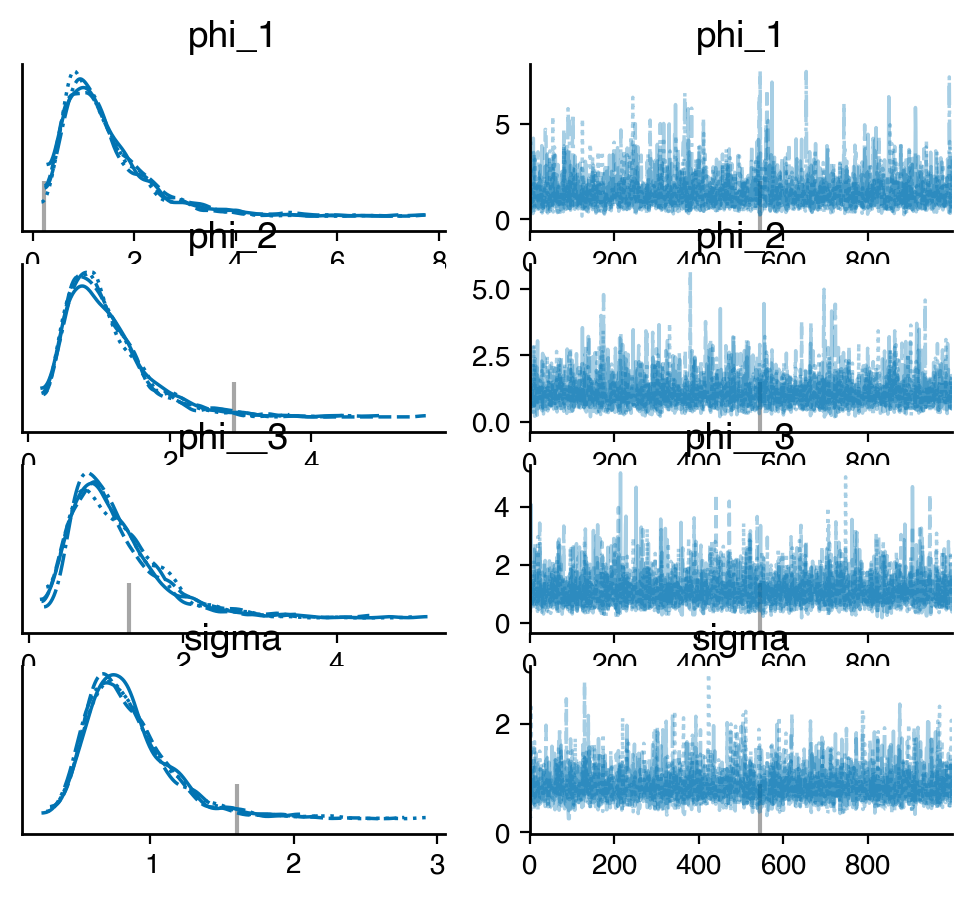

In [9]:
# reduced model
red_enz_kin = pm.Model()
with red_enz_kin:
    # priors
    phi_1 = pm.LogNormal("phi_1", mu=0.0, sigma=0.5)
    phi_2 = pm.LogNormal("phi_2", mu=0.0, sigma=0.5)
    phi_3 = pm.LogNormal("phi__3", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # compte model
    y = (phi_1*u_samp)/(u_samp**2 + phi_2*u_samp + phi_3)

    # Likelihood of obs
    y_obs = pm.Normal("Y_obs", mu=y, sigma=sigma, observed=noisy_data)

with red_enz_kin: # sampling
    idata_red_enz_kin_prior = pm.sample_prior_predictive(samples=50, random_seed=rng)
    idata_red_enz_kin = pm.sample(random_seed=rng, idata_kwargs={'log_likelihood':True})

# plot traces and marginal densities
fig, ax = plt.subplots(4,2, figsize=(6,5))
az.plot_trace(idata_red_enz_kin, axes=ax)
plt.show()

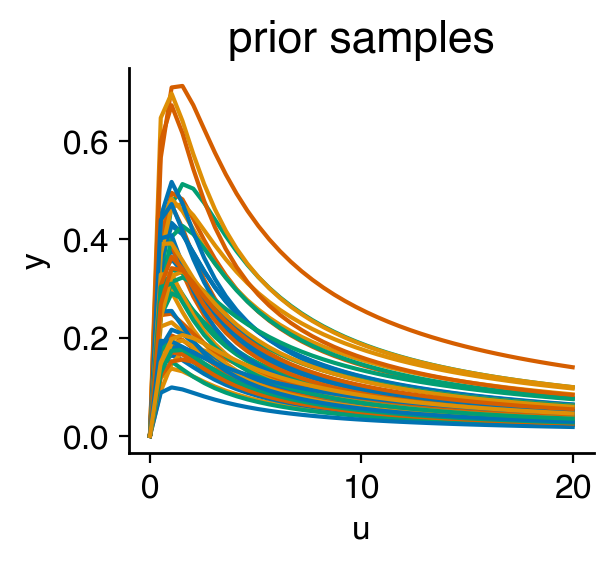

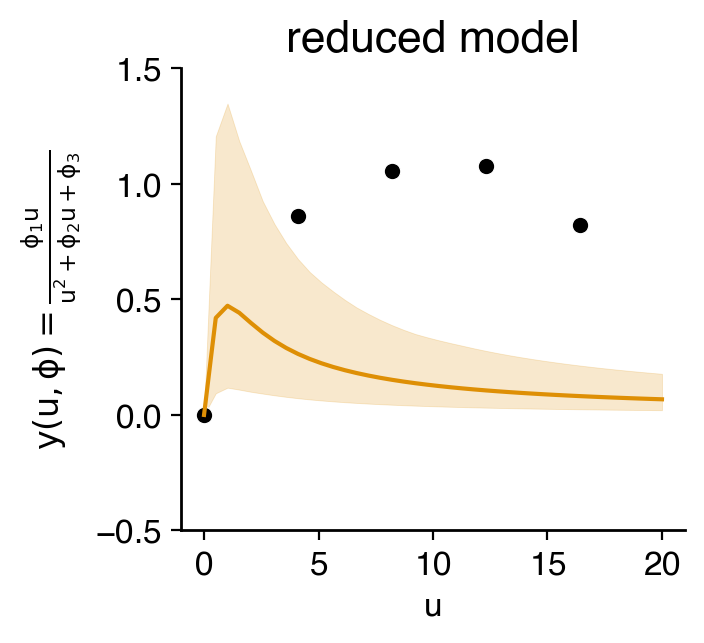

In [10]:
prior_samples = idata_red_enz_kin_prior.to_dict()['prior']

# prior
fig, ax = plt.subplots(figsize=(3,2.5))
for i in range(50):
    theta = np.array([prior_samples['phi_1'][0][i],
                      prior_samples['phi_2'][0][i],
                      prior_samples['phi__3'][0][i]])
    vals = sub_enz_red(u, theta)
    data = {'u':u, 'y':vals}
    sns.lineplot(data, x='u', y='y', ax=ax)
ax.set_title('prior samples')

# posterior
fig1, ax1 = plt.subplots(figsize=(3.25,3))
posterior_samples = idata_red_enz_kin.to_dict()['posterior']
red = {'run':{}, 'u':{}, 'y':{}}
red_ss = np.zeros((400,))
names = ['run'+str(i) for i in range(400)]
idxs = np.linspace(0, (400*u.shape[0]-1), 400*u.shape[0])
cnt = 0
for i in range(400):
    theta = np.array([posterior_samples['phi_1'].flatten()[i],
                        posterior_samples['phi_2'].flatten()[i],
                        posterior_samples['phi__3'].flatten()[i],])
    vals = sub_enz_red(u, theta)
    red_ss[i] = vals[-1]
    for j in range(u.shape[0]):
        red['run'][int(idxs[cnt])] = names[i]
        red['u'][int(idxs[cnt])] = u[j]
        red['y'][int(idxs[cnt])] = vals[j]
        cnt += 1
red_df=pd.DataFrame.from_dict(red,)
sns.lineplot(data=red_df,
            x='u',
            y='y',
            # style='patient',
            # hue='patient',
            color=cb[1],
            legend=False,
            errorbar=('pi', 95), # percentile interval form 2.5th to 97.5th
            ax=ax1)
sns.scatterplot(data=dat, x='u', y='y', ax=ax1, color='k')
ax1.set_title('reduced model')
ax1.set_ylim([-0.5, 1.5])
ax1.set_ylabel(r'$y(u, \phi) = \frac{\phi_1 u}{u^2 + \phi_2 u + \phi_3}$')
# ax1.set_aspect(1.0)
fig1.savefig('../../figures/enzyme_kinetics/red_post_traj.pdf', bbox_inches='tight')
plt.show()

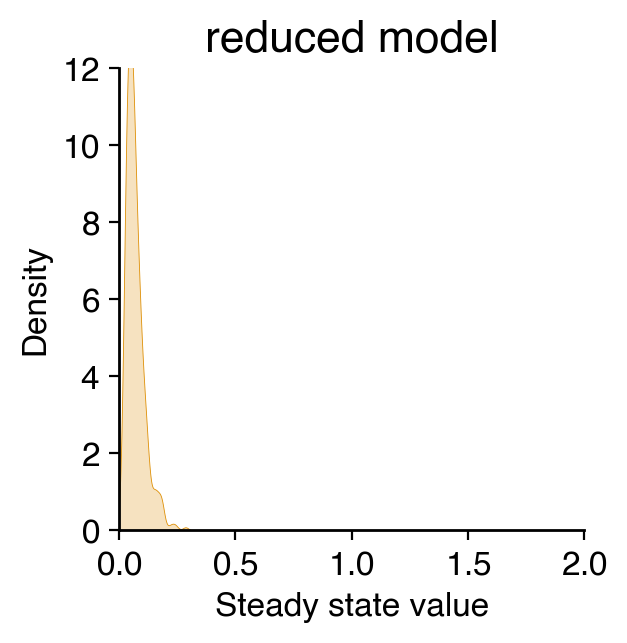

In [11]:
fig2, ax2 = plt.subplots(figsize=(3,3))
dns = sns.kdeplot(red_ss,
            fill=True,
            ax=ax2, 
            color=cb[1], 
            label='reduced model')
ax2.set_xlabel('Steady state value')
ax2.set_title('reduced model')
ax2.set_xlim([0, 2.0])
ax2.set_ylim([0, 12.0])
fig2.savefig('../../figures/enzyme_kinetics/red_post_dist.pdf', bbox_inches='tight')
plt.show()

The exponential model...

Sampling: [Y_obs, sigma, theta_1, theta_2, theta_3]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2, theta_3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


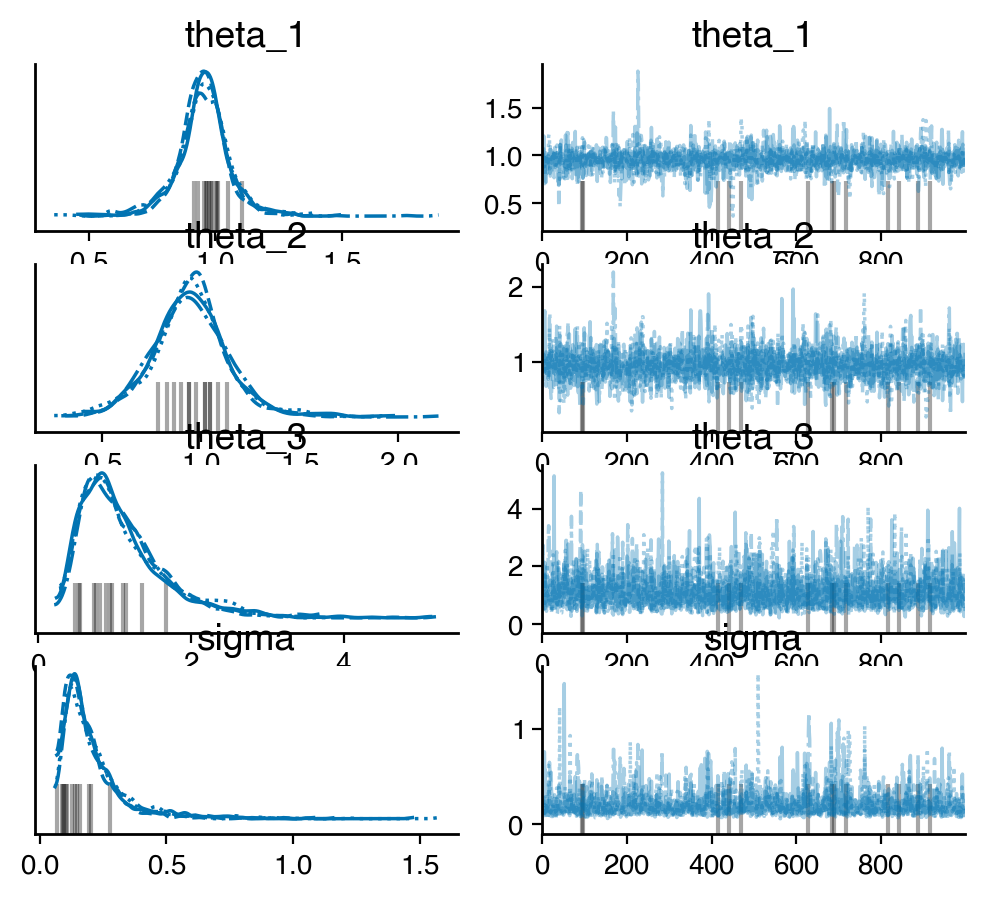

In [12]:
# exponential model
exp_pm = pm.Model()
with exp_pm:
    # priors
    theta_1 = pm.LogNormal("theta_1", mu=0.0, sigma=0.5)
    theta_2 = pm.LogNormal("theta_2", mu=0.0, sigma=0.5)
    theta_3 = pm.LogNormal("theta_3", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # compte model
    y = theta_1 - theta_2*np.exp(-theta_3*u_samp)

    # Likelihood of obs
    y_obs = pm.Normal("Y_obs", mu=y, sigma=sigma, observed=noisy_data)

with exp_pm: # sampling
    idata_exp_pm_prior = pm.sample_prior_predictive(samples=50, random_seed=rng)
    idata_exp_pm = pm.sample(random_seed=rng, idata_kwargs={'log_likelihood':True})

# plot traces and marginal densities
fig, ax = plt.subplots(4,2, figsize=(6,5))
az.plot_trace(idata_exp_pm, axes=ax)
plt.show()

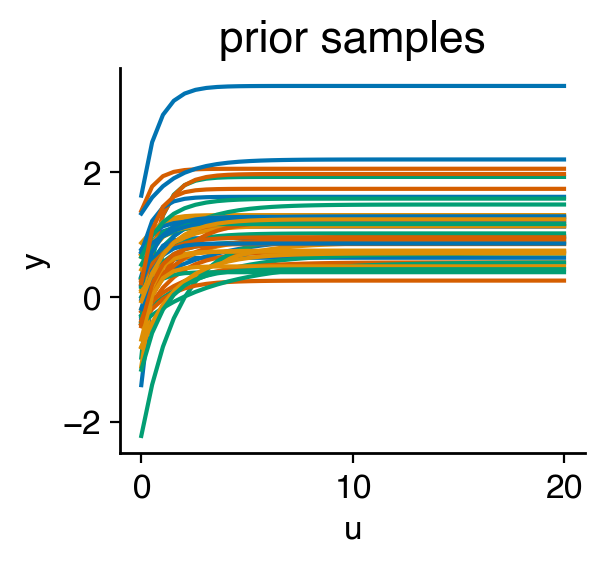

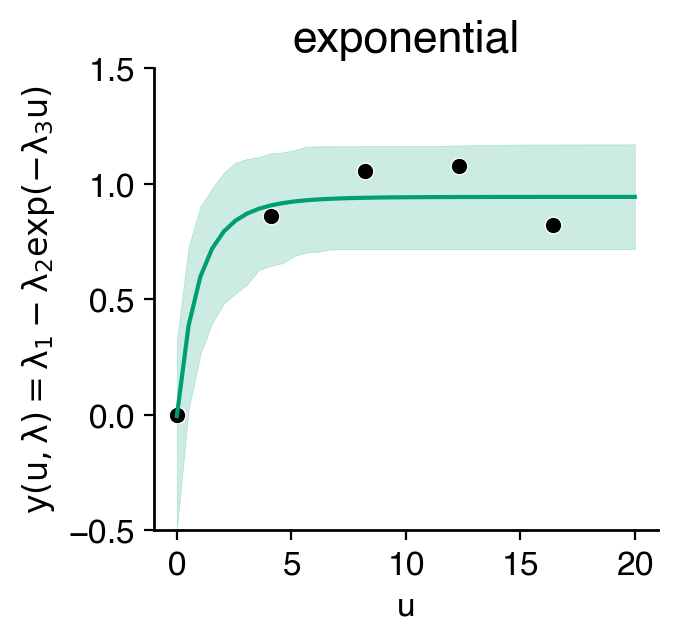

In [13]:
prior_samples = idata_exp_pm_prior.to_dict()['prior']

# prior
fig, ax = plt.subplots(figsize=(3,2.5))
for i in range(50):
    theta = np.array([prior_samples['theta_1'][0][i],
                      prior_samples['theta_2'][0][i],
                      prior_samples['theta_3'][0][i]])
    vals = scal_exp(u, theta)
    data = {'u':u, 'y':vals}
    sns.lineplot(data, x='u', y='y', ax=ax)
ax.set_title('prior samples')

# posterior
fig1, ax1 = plt.subplots(figsize=(3.25,3))
posterior_samples = idata_exp_pm.to_dict()['posterior']
exp_dict = {'run':{}, 'u':{}, 'y':{}}
exp_ss = np.zeros((400,))
names = ['run'+str(i) for i in range(400)]
idxs = np.linspace(0, (400*u.shape[0]-1), 400*u.shape[0])
cnt = 0
for i in range(400):
    theta = np.array([posterior_samples['theta_1'].flatten()[i],
                        posterior_samples['theta_2'].flatten()[i],
                        posterior_samples['theta_3'].flatten()[i],])
    vals = scal_exp(u, theta)
    exp_ss[i] = vals[-1]
    for j in range(u.shape[0]):
        exp_dict['run'][int(idxs[cnt])] = names[i]
        exp_dict['u'][int(idxs[cnt])] = u[j]
        exp_dict['y'][int(idxs[cnt])] = vals[j]
        cnt += 1
exp_df=pd.DataFrame.from_dict(exp_dict,)
sns.lineplot(data=exp_df,
            x='u',
            y='y',
            # style='patient',
            # hue='patient',
            color=cb[2],
            legend=False,
            errorbar=('pi', 95), # percentile interval form 2.5th to 97.5th
            ax=ax1)
sns.scatterplot(data=dat, x='u', y='y', ax=ax1, color='k')
ax1.set_title('exponential')
ax1.set_ylim([-0.5, 1.5])
ax1.set_ylabel(r'$y(u, \lambda) = \lambda_1 - \lambda_2 \exp(-\lambda_3 u)$')
fig1.savefig('../../figures/enzyme_kinetics/exp_post_traj.pdf', bbox_inches='tight')
plt.show()

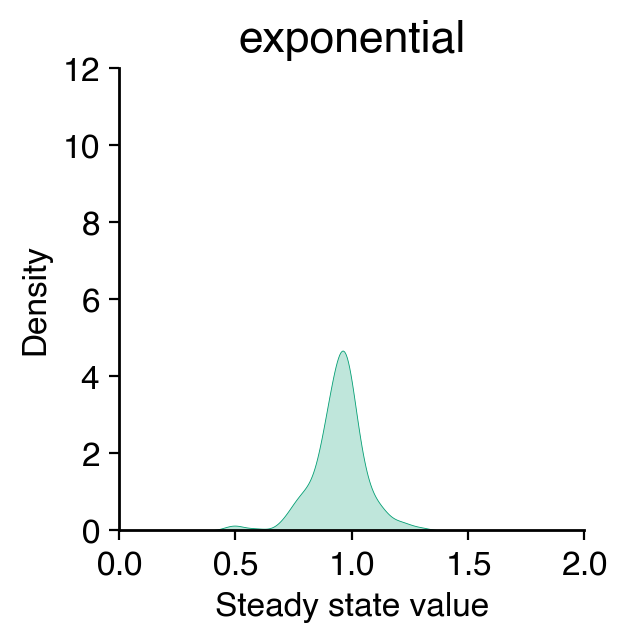

In [14]:
fig2, ax2 = plt.subplots(figsize=(3,3))
dns = sns.kdeplot(exp_ss,
            fill=True,
            ax=ax2, 
            color=cb[2], 
            label='exponential')
dns.set_xlabel('Steady state value')
dns.set_title('exponential')
dns.set_xlim([0, 2.0])
dns.set_ylim([0, 12.0])
fig2.savefig('../../figures/enzyme_kinetics/exp_post_dist.pdf', bbox_inches='tight')

Lastly, the sigmoidal model... Here we let the prior for $\theta_1$ be the standard normal, because this param can be negative.

Sampling: [Y_obs, sigma, theta_1, theta_2, theta_3, theta_4, theta_5]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2, theta_3, theta_4, theta_5, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


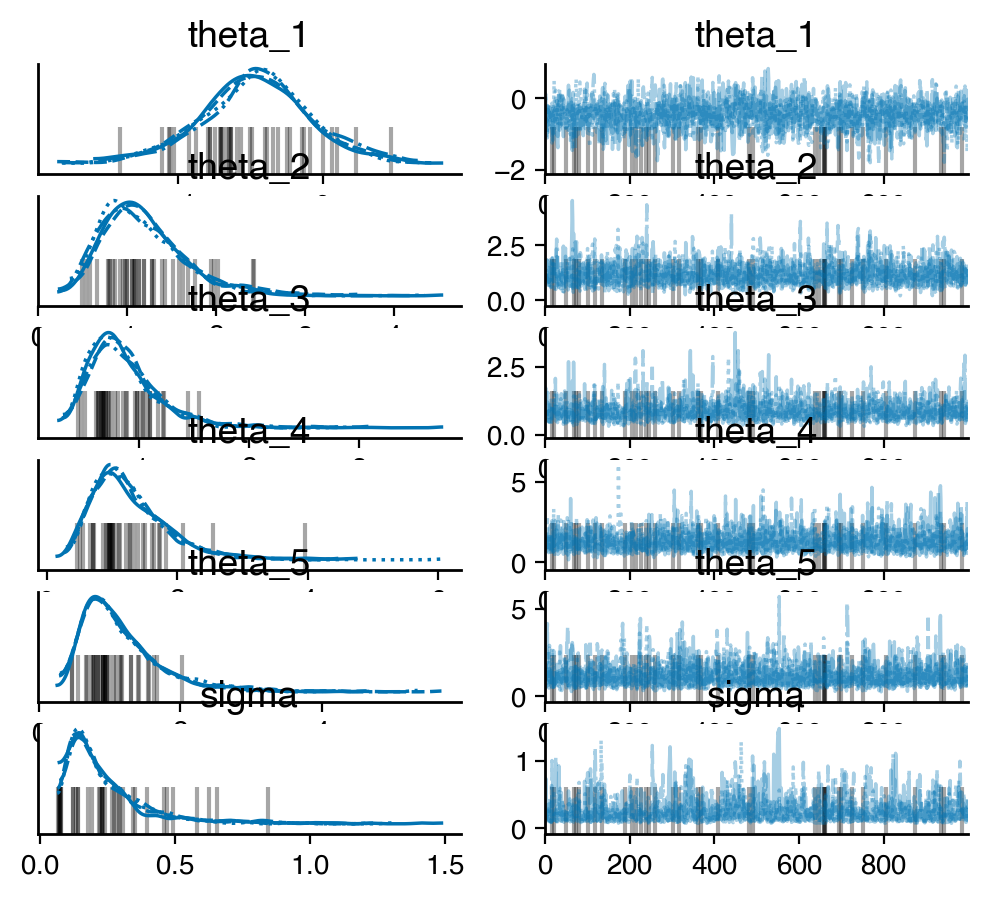

In [15]:
# sigmoidal model
sig_pm = pm.Model()
with sig_pm:
    # priors
    theta_1 = pm.Normal("theta_1")
    theta_2 = pm.LogNormal("theta_2", mu=0.0, sigma=0.5)
    theta_3 = pm.LogNormal("theta_3", mu=0.0, sigma=0.5)
    theta_4 = pm.LogNormal("theta_4", mu=0.0, sigma=0.5)
    theta_5 = pm.LogNormal("theta_5", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # compte model
    y = theta_1 + (theta_2 / (theta_3 + theta_4*np.exp(-theta_5*u_samp)))

    # Likelihood of obs
    y_obs = pm.Normal("Y_obs", mu=y, sigma=sigma, observed=noisy_data)

with sig_pm: # sampling
    idata_sig_pm_prior = pm.sample_prior_predictive(samples=50, random_seed=rng)
    idata_sig_pm = pm.sample(random_seed=rng, target_accept=0.9, idata_kwargs={'log_likelihood':True})

# plot traces and marginal densities
fig, ax = plt.subplots(6,2, figsize=(6,5))
az.plot_trace(idata_sig_pm, axes=ax)
plt.show()

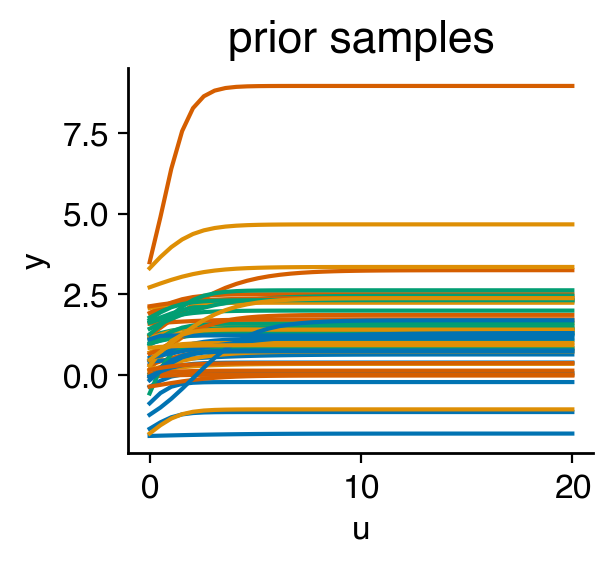

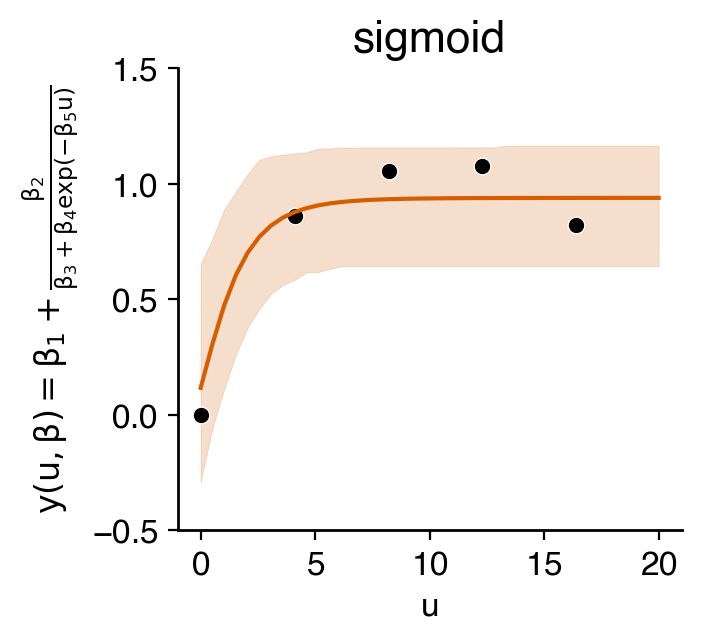

In [16]:
prior_samples = idata_sig_pm_prior.to_dict()['prior']
fig, ax = plt.subplots(figsize=(3,2.5))

# prior
for i in range(50):
    theta = np.array([prior_samples['theta_1'][0][i],
                      prior_samples['theta_2'][0][i],
                      prior_samples['theta_3'][0][i],
                      prior_samples['theta_4'][0][i],
                      prior_samples['theta_5'][0][i]])
    vals = sigmoid(u, theta)
    data = {'u':u, 'y':vals}
    sns.lineplot(data, x='u', y='y', ax=ax)
ax.set_title('prior samples')

# posterior
fig1, ax1 = plt.subplots(figsize=(3.25,3))
posterior_samples = idata_sig_pm.to_dict()['posterior']
sig_dict = {'run':{}, 'u':{}, 'y':{}}
sig_ss = np.zeros((400,))
names = ['run'+str(i) for i in range(400)]
idxs = np.linspace(0, (400*u.shape[0]-1), 400*u.shape[0])
cnt = 0
for i in range(400):
    theta = np.array([posterior_samples['theta_1'].flatten()[i],
                        posterior_samples['theta_2'].flatten()[i],
                        posterior_samples['theta_3'].flatten()[i],
                        posterior_samples['theta_4'].flatten()[i],
                        posterior_samples['theta_5'].flatten()[i],])
    vals = sigmoid(u, theta)
    sig_ss[i] = vals[-1]
    for j in range(u.shape[0]):
        sig_dict['run'][int(idxs[cnt])] = names[i]
        sig_dict['u'][int(idxs[cnt])] = u[j]
        sig_dict['y'][int(idxs[cnt])] = vals[j]
        cnt += 1
sig_df=pd.DataFrame.from_dict(sig_dict,)
sns.lineplot(data=sig_df,
            x='u',
            y='y',
            # style='patient',
            # hue='patient',
            color=cb[3],
            legend=False,
            errorbar=('pi', 95), # percentile interval form 2.5th to 97.5th
            ax=ax1)
sns.scatterplot(data=dat, x='u', y='y', ax=ax1, color='k')
ax1.set_title('sigmoid')
ax1.set_ylim([-0.5, 1.5])
ax1.set_ylabel(r'$y(u, \beta) = \beta_1 + \frac{\beta_2}{\beta_3 + \beta_4 \exp(-\beta_5 u)}$')
fig1.savefig('../../figures/enzyme_kinetics/sig_post_traj.pdf', bbox_inches='tight')
plt.show()

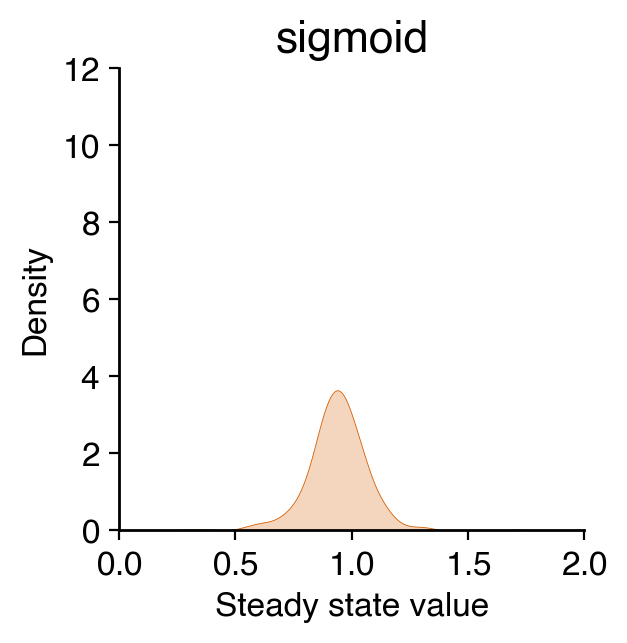

In [17]:
fig2, ax2 = plt.subplots(figsize=(3,3))
dns = sns.kdeplot(sig_ss,
            fill=True,
            ax=ax2, 
            color=cb[3], 
            label='sigmoid')
dns.set_xlabel('Steady state value')
dns.set_xlim([0, 2.0])
dns.set_ylim([0, 12.0])
dns.set_title('sigmoid')
fig2.savefig('../../figures/enzyme_kinetics/sig_post_dist.pdf', bbox_inches='tight')

Axes(0.125,0.11;0.775x0.77)


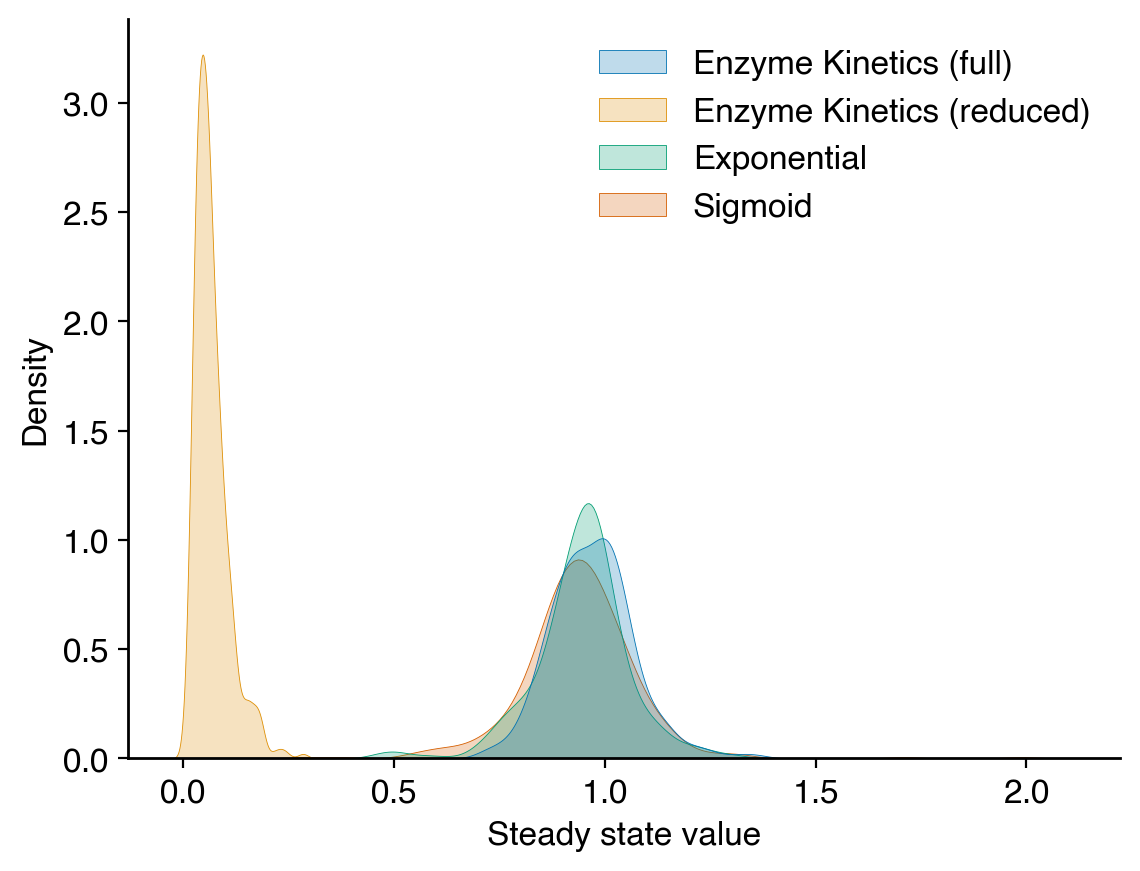

In [20]:
# plot histograms of each model's predicted steady-state distribution
steady_states = {'Enzyme Kinetics (full)':full_ss,
                 'Enzyme Kinetics (reduced)':red_ss,
                 'Exponential':exp_ss,
                 'Sigmoid':sig_ss}
steady_states_df = pd.DataFrame(steady_states)

comb = sns.kdeplot(data=steady_states_df,
    fill=True,
    multiple='layer',
    legend=True,
    palette=cb,
)
comb.set_xlabel('Steady state value')
print(comb)
plt.setp(comb.lines, alpha=1.0)

In [21]:
cb

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0)]

In [22]:
def m_star(sigma_0, mu, one_vec):
    """ mu as column vec"""
    sigma_0_inv = np.linalg.inv(sigma_0)
    temp = np.matmul(one_vec.transpose(), sigma_0_inv)
    num = np.matmul(temp, mu)
    den = np.matmul(temp, one_vec)
    return num / den

def s_star_2(sigma_0, delta_0, mu, one_vec, m_star, k):
    """ mu as column vec"""
    sigma_0_inv = np.linalg.inv(sigma_0)
    temp0 = (m_star*one_vec - mu).transpose()
    temp1 = np.matmul(temp0, sigma_0_inv)
    num = delta_0 + np.matmul(temp1, mu)
    temp2 = np.matmul(one_vec.transpose(), sigma_0_inv)
    den = (delta_0 + k - 1)*np.matmul(temp2, one_vec)
    return num / den

def var_consensus(delta_0, k, s_star_2):
    return (delta_0 + k - 1)*s_star_2/(delta_0 + k - 3)

def deg_of_freedom(delta_0, k):
    return delta_0 + k - 1

In [23]:
# get stats of each set of samples
mean_ss = steady_states_df.mean()
std_ss = steady_states_df.std()
print('Mean: \n', mean_ss, '\n')
print('Std: \n', std_ss)

# compute covariance matrix
# this will be the prior for the winkler mixing
steady_states = np.vstack((full_ss, red_ss, exp_ss, sig_ss))
sigma_0 = np.abs(np.cov(steady_states))
print(sigma_0)


Mean: 
 Enzyme Kinetics (full)       0.970747
Enzyme Kinetics (reduced)    0.067734
Exponential                  0.943948
Sigmoid                      0.939690
dtype: float64 

Std: 
 Enzyme Kinetics (full)       0.098390
Enzyme Kinetics (reduced)    0.040097
Exponential                  0.113725
Sigmoid                      0.141093
dtype: float64
[[9.68054934e-03 6.57317513e-05 3.59360328e-04 9.64956609e-04]
 [6.57317513e-05 1.60773114e-03 2.96903432e-05 9.42240379e-05]
 [3.59360328e-04 2.96903432e-05 1.29332804e-02 1.12255773e-04]
 [9.64956609e-04 9.42240379e-05 1.12255773e-04 1.99072287e-02]]


### Winkler mixing with unknown covariance

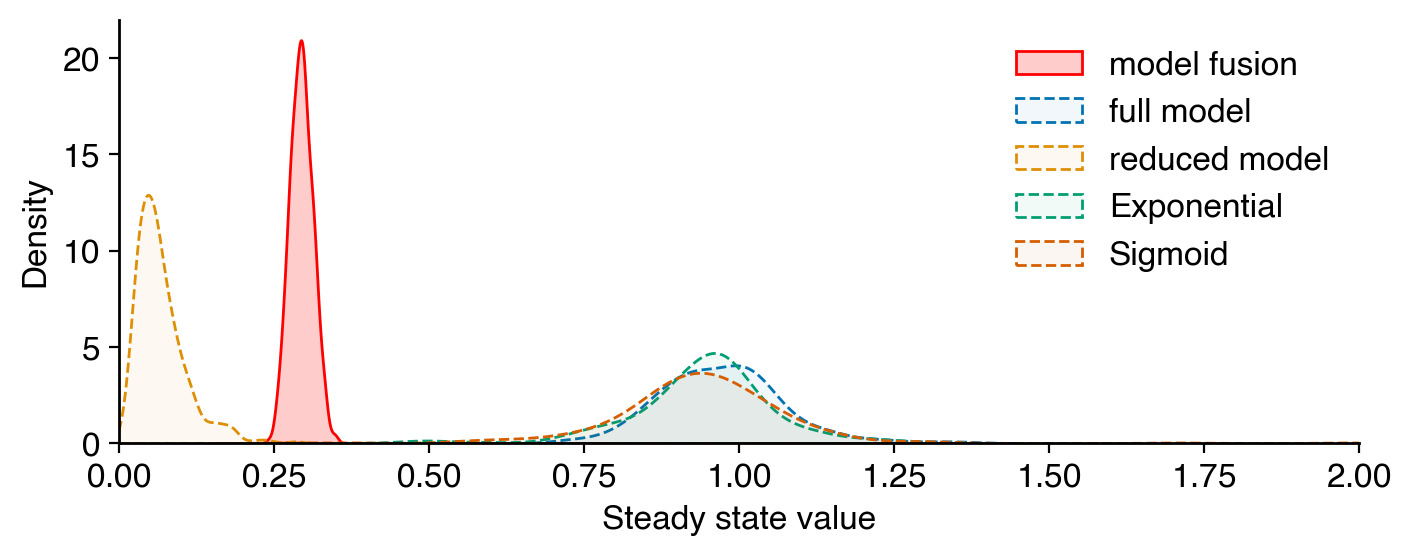

In [65]:
# TODO This currently just uses mean and cov for each population of samples
# we are not fitting a Gaussian! Look into fitting a Gaussian!
mu = mean_ss.values.reshape((4,1))
# print(mu)
one_vec = np.ones((4,1))
nsamples= 400

k = 2
delta_0 = 100
mean_cons = m_star(sigma_0, mu, one_vec)
s_star2 = s_star_2(sigma_0, delta_0, mu, one_vec, mean_cons, k)
var_cons = var_consensus(delta_0, k, s_star2)
dof = deg_of_freedom(delta_0, k)

fusion_weights = (np.linalg.inv(sigma_0)@one_vec)/(one_vec.T @ np.linalg.inv(sigma_0) @ one_vec)
# reshuffle to match ordering from pseudoBMA
tmp_full = np.copy(fusion_weights)[0]
tmp_red = np.copy(fusion_weights)[1]
tmp_exp = np.copy(fusion_weights)[2]
tmp_sig = np.copy(fusion_weights)[3]
fusion_weights = np.array([tmp_full, tmp_exp, tmp_sig, tmp_red])
cons_t = t(df=dof, loc=mean_cons, scale=np.sqrt(np.abs(var_cons)))
cons_t_samples = cons_t.rvs(nsamples)


# plot histograms of each model's predicted steady-state distribution
steady_states = {'Enzyme Kinetics (full)':full_ss,
                 'Enzyme Kinetics (reduced)':red_ss,
                 'Exponential':exp_ss,
                 'Sigmoid':sig_ss,
                 'Consensus':cons_t_samples}
steady_states_df = pd.DataFrame(steady_states)

# comb = sns.displot(data=steady_states_df,
#     kind='kde',
#     height=4,
#     aspect=2,
#     fill=True,
#     multiple='layer',
#     legend=True,
# )
# comb.set_xlabels('Steady state value')
# comb.set_xlim([0.0, 2.0])


fig, ax = plt.subplots(1, 1, figsize=(8, 2.75))
sns.kdeplot(data=cons_t_samples,
    fill=True, ax=ax, alpha=0.2,linewidth=1.,linestyle='-',
    label='model fusion',color='red')
sns.kdeplot(data=full_ss,
    fill=True, ax=ax, alpha=0.05, linewidth=1.,linestyle='--',
    label='full model',color=cb[0])
sns.kdeplot(data=red_ss,
    fill=True, ax=ax, alpha=0.05,linewidth=1.,linestyle='--',
    label='reduced model',color=cb[1])
sns.kdeplot(data=exp_ss,
    fill=True, ax=ax, alpha=0.05,linewidth=1.,linestyle='--',
    label='Exponential',color=cb[2])
sns.kdeplot(data=sig_ss,
    fill=True, ax=ax, alpha=0.05,linewidth=1.,linestyle='--',
    label='Sigmoid',color=cb[3])
    
ax.legend()
ax.set_xlabel('Steady state value')
ax.set_xlim([0.0, 2.0])
fig.savefig('../../figures/enzyme_kinetics/consensus_winkler.pdf', bbox_inches='tight')

### Now we want to compute Bayesian information criterion and model scores using ArViz

In [66]:
# construct dictionary for inference data
inf_dict = {'full_model': idata_full_enz_kin,
            'reduced_model': idata_red_enz_kin,
            'exponential_model': idata_exp_pm,
            'sigmoid_model': idata_sig_pm,}

# call the ArViz compare function to generate the comparison statistics
model_comp_waic = az.compare(inf_dict, ic='waic', method='BB-pseudo-BMA', seed=123)
model_comp_loo = az.compare(inf_dict, ic='loo', method='BB-pseudo-BMA', seed=123)
print(model_comp_waic)
print(model_comp_loo)

                   rank  elpd_waic    p_waic  elpd_diff    weight        se  \
full_model            0   1.748664  1.638804   0.000000  0.559747  0.678802   
exponential_model     1   1.139280  1.585596   0.609384  0.313445  0.471002   
sigmoid_model         2   0.117975  2.080383   1.630689  0.126571  0.613306   
reduced_model         3  -6.137370  0.326357   7.886034  0.000237  0.289912   

                        dse  warning scale  
full_model         0.000000     True   log  
exponential_model  0.730092     True   log  
sigmoid_model      1.048439     True   log  
reduced_model      0.700257    False   log  
                   rank  elpd_loo     p_loo  elpd_diff    weight        se  \
full_model            0  1.560281  1.827187   0.000000  0.543554  0.781793   
exponential_model     1  1.056815  1.668060   0.503466  0.336526  0.670973   
sigmoid_model         2 -0.183765  2.382123   1.744045  0.119642  0.617372   
reduced_model         3 -6.148668  0.337655   7.708949  0.000278  0

/Users/natetest/micromamba/envs/pymc5_env/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/micromamba/envs/pymc5_env/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/micromamba/envs/pymc5_env/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/micromamba/envs/pymc5_en

### Now use the weights to construct the averaged distributions
Just take a weighed average of push forward samples

In [67]:
# plotting new consensus distributions
ss_numpy_loo = np.vstack((full_ss, exp_ss, sig_ss, red_ss))
ss_numpy_waic = np.vstack((full_ss, exp_ss, sig_ss, red_ss))
for i in range(4):
    ss_numpy_loo[i,:] *= model_comp_loo['weight'].to_numpy()[i]
    ss_numpy_waic[i,:] *= model_comp_waic['weight'].to_numpy()[i]

consensus_loo = np.sum(ss_numpy_loo, axis=0)
consensus_waic = np.sum(ss_numpy_waic, axis=0)

steady_states = {'Enzyme Kinetics (full)':full_ss,
                 'Enzyme Kinetics (reduced)':red_ss,
                 'Exponential':exp_ss,
                 'Sigmoid':sig_ss,}
consensus_ss = {'Consensus LOO':consensus_loo,
             'Consensus WAIC':consensus_waic,
             'Consensus Winkler':cons_t_samples}
ss = {'Enzyme Kinetics (full)':full_ss,
    'Enzyme Kinetics (reduced)':red_ss,
    'Exponential':exp_ss,
    'Sigmoid':sig_ss,
    'Consensus LOO':consensus_loo,
    'Consensus WAIC':consensus_waic,}
consensus_df = pd.DataFrame(consensus_ss)
steady_states_df = pd.DataFrame(steady_states)
ss_df = pd.DataFrame(ss)

In [68]:
ss = {'Enzyme Kinetics (full)':full_ss,
    'Enzyme Kinetics (reduced)':red_ss,
    'Exponential':exp_ss,
    'Sigmoid':sig_ss,
    'Consensus LOO':consensus_loo,
    'Consensus WAIC':consensus_waic,}

ss_new = {'model':{}, 'sample':{}}
old = 0
for idx, dis in zip(range(len(ss.keys())), ss.keys()):
    for i in range(len(ss[dis])):
        if idx != 0:
            j = (1+i+old)
        else:
            j=i
        ss_new['model'][j] = dis
        ss_new['sample'][j] = ss[dis][i]
    old = j

ss_df = pd.DataFrame(ss_new)
print(ss_df)

                       model    sample
0     Enzyme Kinetics (full)  0.881783
1     Enzyme Kinetics (full)  0.878189
2     Enzyme Kinetics (full)  0.731297
3     Enzyme Kinetics (full)  1.010314
4     Enzyme Kinetics (full)  0.992269
...                      ...       ...
2395          Consensus WAIC  0.765581
2396          Consensus WAIC  0.808521
2397          Consensus WAIC  0.831807
2398          Consensus WAIC  0.840286
2399          Consensus WAIC  0.849199

[2400 rows x 2 columns]


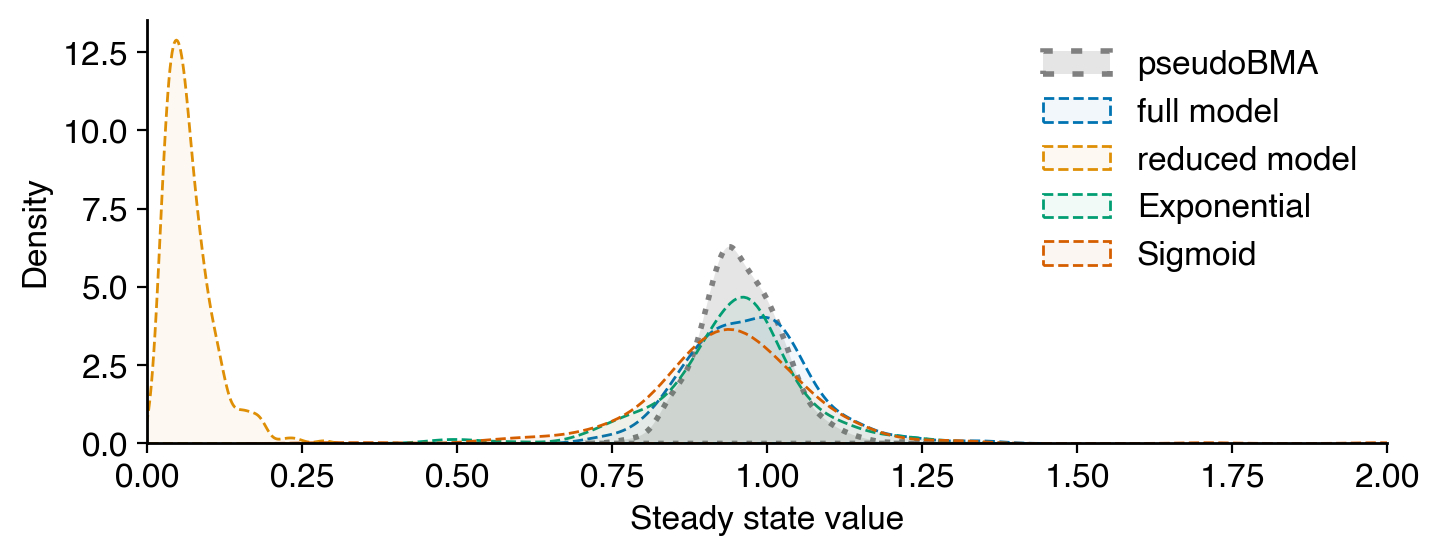

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2.75))
# sns.kdeplot(data=consensus_loo,
#     fill=True, ax=ax, alpha=0.2,linewidth=1.,linestyle='-',
#     label='Consensus LOO',color='grey')
sns.kdeplot(data=consensus_waic,
    fill=True, ax=ax, alpha=0.2,linewidth=2.,linestyle=':',
    label='pseudoBMA',color='grey')
sns.kdeplot(data=full_ss,
    fill=True, ax=ax, alpha=0.05, linewidth=1.,linestyle='--',
    label='full model',color=cb[0])
sns.kdeplot(data=red_ss,
    fill=True, ax=ax, alpha=0.05,linewidth=1.,linestyle='--',
    label='reduced model',color=cb[1])
sns.kdeplot(data=exp_ss,
    fill=True, ax=ax, alpha=0.05,linewidth=1.,linestyle='--',
    label='Exponential',color=cb[2])
sns.kdeplot(data=sig_ss,
    fill=True, ax=ax, alpha=0.05,linewidth=1.,linestyle='--',
    label='Sigmoid',color=cb[3])
    
ax.legend()
ax.set_xlabel('Steady state value')
ax.set_xlim([0.0, 2.0])
fig.savefig('../../figures/enzyme_kinetics/consensus_info_crit.pdf', bbox_inches='tight')

In [70]:
# create averaged traces
cons_waic_dict = {'run':{}, 'u':{}, 'y':{}}
cons_fusion_dict = {'run':{}, 'u':{}, 'y':{}}

for i in range(len(exp_df)):
    vals = np.array([full_df['y'][i], exp_df['y'][i], sig_df['y'][i], red_df['y'][i]])
    cons_waic_dict['run'][i] = exp_df['run'][i]
    cons_waic_dict['u'][i] = exp_df['u'][i]
    cons_waic_dict['y'][i] = np.inner(vals, model_comp_waic['weight'].to_numpy())
    cons_fusion_dict['run'][i] = exp_df['run'][i]
    cons_fusion_dict['u'][i] = exp_df['u'][i]
    cons_fusion_dict['y'][i] = np.inner(vals, fusion_weights.T)[0]

cons_waic_df = pd.DataFrame(cons_waic_dict)
cons_fusion_df = pd.DataFrame(cons_fusion_dict)

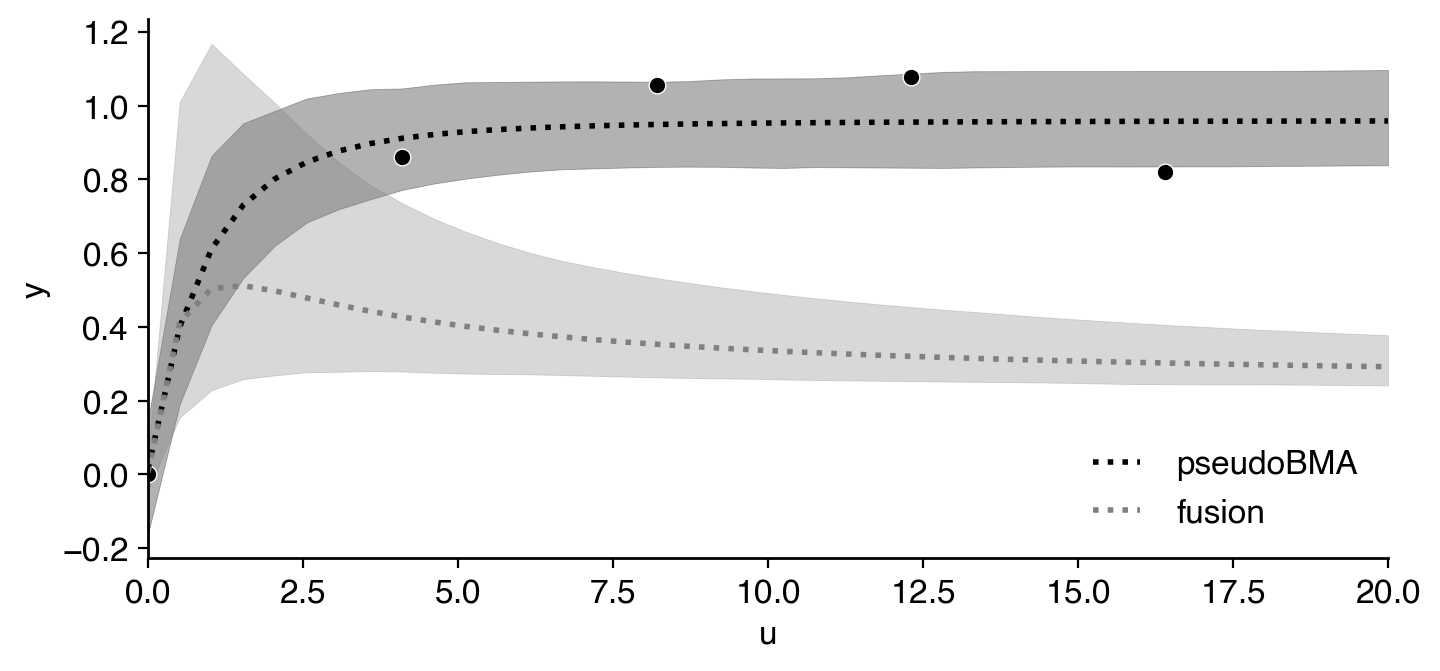

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
sns.lineplot(data=cons_waic_df,
            x='u', y='y',
            color='black', alpha=1.0, linewidth=2.,linestyle=':',
            errorbar=('pi', 95), ax=ax, label='pseudoBMA')
sns.lineplot(data=cons_fusion_df,
            x='u', y='y',
            color='grey', alpha=1.0, linewidth=2.,linestyle=':',
            errorbar=('pi', 95), ax=ax, label='fusion')
for coll,idx in zip(ax.collections, range(len(ax.collections))):
    coll.set_alpha(0.3)

sns.scatterplot(data=dat, x='u', y='y', ax=ax, color='k')
ax.set_xlim([0.0, 20.0])
ax.legend(loc='lower right')
plt.show()
fig.savefig('../../figures/enzyme_kinetics/consensus_info_crit_traces.pdf', bbox_inches='tight')

In [41]:
fusion_weights

array([[0.11215063],
       [0.74743082],
       [0.08878263],
       [0.05163593]])